In [24]:
import numpy as np

## 1.c
The policy in (c) won't outperform (a), because without exploration, the policy will be trapped when alpha is estimated a low value.
The distribution of reach time will be uniform, since it's time-varying alpha every experiment.

In [25]:
class LoopEnv:
    LEFT = 0
    RIGHT = 1

    def __init__(self, target_s, num_states, alpha=None):
        self.alpha = alpha
        self.target_s = target_s
        self.num_states = num_states

    def step(self, s, a):
        if self.alpha is None:
            # random alpha between 0.5 and 1
            alpha = np.random.rand() * 0.5 + 0.5
        else:
            alpha = self.alpha

        success = True
        if a == LoopEnv.RIGHT:
            s += 1
        elif a == LoopEnv.LEFT:
            # random move
            if np.random.rand() < alpha:
                s -= 1
            else:
                success = False

        if s < 0:
            s = self.num_states

        done = False
        if s == self.target_s:
            done = True

        return s, success, done

In [ ]:
num_steps = 1000000
num_episodes = 100
begin_s = 450000
target_s = 1000000
alpha_hat_t = 1.0

env = LoopEnv(target_s=target_s, num_states=target_s)


def get_best_action(s, target_s, alpha_hat_t):
    if alpha_hat_t == 0:
        return LoopEnv.RIGHT
    left_distance = s
    right_distance = target_s - s
    steps_to_left = left_distance / alpha_hat_t
    steps_to_right = right_distance
    if steps_to_left < steps_to_right:
        return LoopEnv.LEFT
    else:
        return LoopEnv.RIGHT


num_steps_success = []
action_histories = []

for ep in range(num_episodes):
    s = begin_s
    alpha_hat_t = 1.0
    num_step_current_episode = 0
    action_history = []
    n_left = 0.0
    n_left_left = 0.0
    for i in range(num_steps):
        a = get_best_action(s, target_s, alpha_hat_t)
        s, success, done = env.step(s, a)
        num_step_current_episode += 1
        action_history.append(a)

        if a == LoopEnv.LEFT:
            n_left += 1.0
            if success:
                n_left_left += 1.0

        if done:
            num_steps_success.append(num_step_current_episode)
            print(f"Episode {ep} finished in {num_step_current_episode} steps")
            break

        if n_left > 0:
            alpha_hat_t = n_left_left / n_left
    action_histories.append(action_history[:100])


## 1.d
The policy in (d), the performance depends on the first few steps because no exploration is done. But since it's a time-invariant setup this time, it will outperform the robust policy when the alpha is high enough. 
Based on the experiment, it's likely to finish faster than the robust policy when alpha is highly than roughly 0.86.
The distribution of reach time decreases as alpha increases close to 1. but with fluctuations, because the first steps are crucial.

In [ ]:
action_histories = []
# alpha distribution as uniform between 0.5 and 1, a linspace
alpha_distribution = np.linspace(0.5, 1, num_episodes)
num_steps_success = np.zeros(num_episodes)
for ep in range(num_episodes):
    env = LoopEnv(target_s=target_s, num_states=target_s, alpha=alpha_distribution[ep])
    s = begin_s
    alpha_hat_t = 1.0
    num_step_current_episode = 0
    action_history = []
    n_left = 0.0
    n_left_left = 0.0
    for i in range(num_steps):
        a = get_best_action(s, target_s, alpha_hat_t)
        s, success, done = env.step(s, a)
        num_step_current_episode += 1

        if a == LoopEnv.LEFT:
            n_left += 1.0
            if success:
                n_left_left += 1.0

        if done:
            num_steps_success[ep] = num_step_current_episode
            print(f"Episode {ep} finished in {num_step_current_episode} steps, alpha: {alpha_distribution[ep]}, alpha_hat: {alpha_hat_t}")
            break

        if n_left > 0.0:
            alpha_hat_t = n_left_left / n_left

    action_histories.append(action_history[:100])


0.18


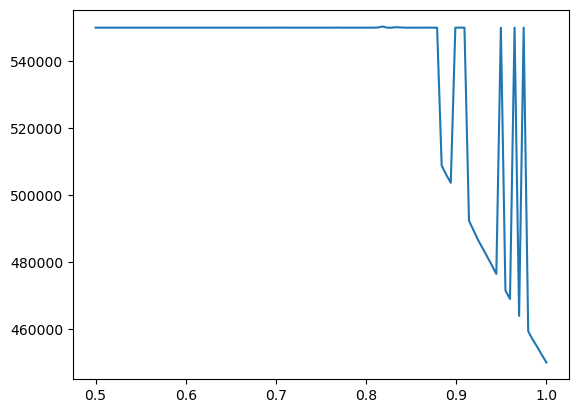

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

# compute how often the num_steps_success is less than 550000
print(np.sum(np.array(num_steps_success) < 550000)/num_episodes)

plt.figure()

plt.plot(alpha_distribution, num_steps_success)

plt.show()



## 1.e

The exploration policy I used, is to define a minimal number of exploration steps must be performed in the beginning of the experiment, but also I compute the change of the estimated alpha, which has to be lower than a threshold, i.e. the estimate of alpha is getting stable.
It stably finishes faster than the robust policy when alpha is higher than roughly 0.82.
The finish time decrease stably as alpha increases, because of the exploration.

In [ ]:
delta_alpha_hat = 1
num_try_steps = 2000
alpha_distribution = np.linspace(0.5, 1, num_episodes)
num_steps_success = np.zeros(num_episodes)
for ep in range(num_episodes):
    env = LoopEnv(target_s=target_s, num_states=target_s, alpha=alpha_distribution[ep])
    s = begin_s
    alpha_hat_t = 1.0
    old_alpha_hat_t = 1
    num_step_current_episode = 0
    n_left = 0
    n_left_left = 0
    for i in range(num_steps):
        if delta_alpha_hat < 0.02 and i > num_try_steps:
            a = get_best_action(s, target_s, alpha_hat_t)
        else:
            a = get_best_action(s, target_s, 1.0)
        s, success, done = env.step(s, a)
        num_step_current_episode += 1

        if a == LoopEnv.LEFT:
            n_left += 1
            if success:
                n_left_left += 1

        if done:
            num_steps_success[ep] = num_step_current_episode
            print(f"Episode {ep} finished in {num_step_current_episode} steps")
            break

        if n_left > 0:
            alpha_hat_t = n_left_left / n_left
            if alpha_hat_t < 1:
                delta_alpha_hat = np.abs(alpha_hat_t - old_alpha_hat_t)

        old_alpha_hat_t = alpha_hat_t


0.35


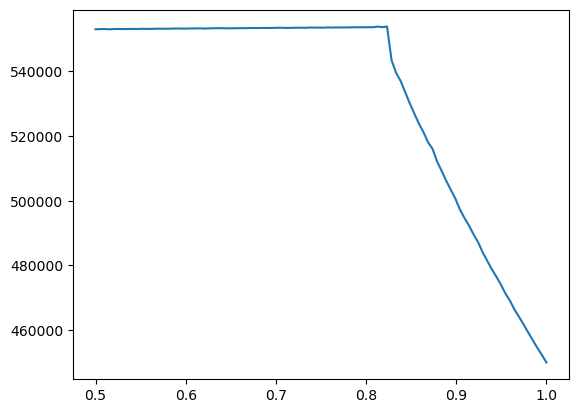

In [44]:

print(np.sum(np.array(num_steps_success) < 550000)/num_episodes)
plt.figure()

plt.plot(alpha_distribution, num_steps_success)

plt.show()

## 2

I use the Q-Learning algorithm to learn the policy, with the following changes:

1. the game, I define the cost of each step as the distance to the target, because the agent has to learn online everytime, the time penalty and one-time success reward is not enough to learn the policy, i.e. the game knows where the target is.
2. Although the question states the agent doesn't know anything about the dynamics, but I made the assumption the agent at least knows if an action is executed successfully or not. If it's not the case, then the agent just has to learn the outcome of the actions, the problem is still learnable but it will take more time.
3. I used an estimation of alpha in the Q-Learning algorithm, same as Question 1, but one alpha for each action. The reward used to update the Q-values is discounted by the estimated alpha.
4. For exploration, when any of the estimation of alpha of all actions is not initialized, i.e. not tried that action enough times, the agent will be forced to explore those actions.

I believe my method is better, because:
1. I force the agent to explore the action space in the beginning of the experiment, compared to passive methods,
2. I use the estimated alpha to update the Q-values, which is intuitive to allocate rewards based on the belief of actions,
3. Instead of fully random choosing actions during exploration, I force the agent to explore the actions that are not tried enough times, which is more efficient.

After 10000 experiment, my method is able to finish the task with around 57.5 steps on average. Based on my comparison, a random exploration policy takes around 75 steps on average, and the vanilla Q-Learning algorithm without considering the uncertainty takes around 110 steps.


In [ ]:
from mountain_gridworld import MountainGridWorld
import numpy as np

env = MountainGridWorld(perfect_obs=True, max_num_steps=100000)

from models.q_learning.q_learning import learn

num_steps = []
for i in range(10000):
    model = learn(env, scene="mountain", max_it=1, alpha=0.3, epsilon=0.0, epsilon_decay=0.95)
    num_steps.append(env.num_steps)

num_steps = np.array(num_steps)
print(np.mean(num_steps))